# Fixed point with noise: compare theory and simulation 
### for $g = 0$. 

In [1]:
import os, time
import numpy as np
from tqdm import tqdm
import pickle
from copy import deepcopy

import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Use cpu.


In [2]:
# Nonlinearity
from scipy.linalg import solve_lyapunov
from scipy.integrate import quad, dblquad
from scipy.optimize import root, root_scalar

nonlin_str = 'erf'
if nonlin_str == 'tanh':
    nonlin = torch.nn.Tanh()
elif nonlin_str == 'erf':
    alpha_phi = np.sqrt(np.pi) / 2
    nonlin = lambda x: torch.special.erf(alpha_phi * x)
    
# Nonlinearity
if nonlin_str == 'tanh':
    phi = lambda x: np.tanh(x)
    dphi = lambda x: 1 - phi(x)**2
    d2phi = lambda x: - 2 * phi(x) * dphi(x)
    d3phi = lambda x: - 2 * (d2phi(x) * phi(x) + dphi(x)**2)
elif nonlin_str == 'erf':
    from scipy.special import erf
    alpha_phi = np.sqrt(np.pi) / 2
    phi = lambda x: erf(alpha_phi * x)
    dphi = lambda x: np.exp(-(alpha_phi * x)**2)
    d2phi = lambda x: -2 * alpha_phi**2 * x * dphi(x)
    d3phi = lambda x: -2 * alpha_phi**2 * (dphi(x) + x * d2phi(x))
    d4phi = lambda x: -2 * alpha_phi**2 * (2 * d2phi(x) + x * d3phi(x))
    d5phi = lambda x: -2 * alpha_phi**2 * (3 * d3phi(x) + x * d4phi(x))
    int_phi = lambda x: x * phi(x) + 2 / np.pi * (dphi(x) - 1)
    int_Dx_Phi = lambda sigma_x: 2 / np.pi * (np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) - 1)
    def root_sigma_x_no_fp(sigma_x, sigma_noise, g):
        """ State amplitude sigma_x in absence of autonomous low-rank fixed point. """
        if g == 0:
            root_s = -sigma_x + sigma_noise
        elif sigma_noise == 0:
            int_Dx_phi_sq = avg_func(lambda x: phi(x)**2, sigma_x)
            root_s = -sigma_x**2 + g**2 * int_Dx_phi_sq
        else:
            int_Dx_Phi_sq = avg_func(lambda x: int_phi(x)**2, sigma_x)
            root_s = -sigma_x**4 + sigma_noise**4 + 2 * g**2 * (int_Dx_Phi_sq - int_Dx_Phi(sigma_x)**2)
        return root_s
    lam_p_sigma_x = lambda sigma_x: np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2)
    sigma_x_lam_p = lambda lam_p: np.sqrt((lam_p**2 - 1) / 2) / alpha_phi
    
    def avg_Phi_dphi_func(sigma_x):
        return (
            2 / np.pi / np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) * (
            np.sqrt((1 + 4 * (alpha_phi * sigma_x)**2) / (1 + 2 * (alpha_phi * sigma_x)**2))
            - 1) )
    def f_Phi_dphi_func(c_0, c_inf, kappa_norm):
        return 2 / np.pi * (
        np.sqrt(
        (1 + 2 * alpha_phi**2 * (2 * kappa_norm**2 + c_0 + c_inf))
        * (1 + 2 * alpha_phi**2 * (c_0 - c_inf))
        ) / (1 + 2 * alpha_phi**2 * (kappa_norm**2 + c_0))
        - 
        1 / np.sqrt(1 + 2 * alpha_phi**2 * (kappa_norm**2 + c_0))
    ) 
    
    # Analytical expressions for averages (not very costly anyways...)
    avg_dphi_func = lambda sigma_x: 1 / np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2)
    avg_d3phi_func = lambda sigma_x: -2 * alpha_phi**2 * (1 + 2 * (alpha_phi * sigma_x)**2)**(-3/2)
    avg_dphi_sq_func = lambda sigma_x: 1 / np.sqrt(1 + 4 * (alpha_phi * sigma_x)**2)
    avg_dphi_sq_p_phi_d2phi_func = lambda sigma_x: 1 / (1 + 2 * (alpha_phi * sigma_x)**2 ) * avg_dphi_sq_func(sigma_x)


# Mean field theory functions
# Averages
def avg_func(func, std):
    """ Average 'func' over Gaussian with standard dev. 'std'. """
    pdf = lambda z: np.exp(-z**2/2) / np.sqrt(2 * np.pi)
    return quad(lambda z: pdf(z) * func(std * z), -np.inf, np.inf)[0]
# Predict fixed point variance
def solve_sigma_x(avg_dphi, sigma_x_guess=1):
    x_target = avg_dphi
    func = lambda sigma_x: avg_func(dphi, sigma_x)
    root_log = lambda log_x: -x_target + func(np.exp(log_x))
    sol = root(root_log, x0=np.log(sigma_x_guess), method="hybr")
    if sol["success"]:
        log_sigma_x = sol["x"][0]
        sigma_x = np.exp(log_sigma_x)
        return sigma_x
    else:
        return 0.
    
# Noisy fixed point is shifted.
if nonlin_str == 'erf':
    def avg_dphi_func_root(norm_kappa, sigma_noise):
        return 1 / np.sqrt(1 + np.pi / 2 * (norm_kappa**2 + sigma_noise**2))
else:
    def avg_dphi_func_root(norm_kappa, sigma_noise):
        pdf = lambda z: np.exp(-z**2/2) / np.sqrt(2 * np.pi)
        integrand = lambda u, x: pdf(x) * pdf(u) * dphi(norm_kappa * u + sigma_noise * x)
        return dblquad(integrand, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)[0]
def solve_norm_kappa_noisy(avg_dphi, sigma_noise, norm_kappa_guess=1):
    x_target = avg_dphi
    func = lambda norm_kappa: avg_dphi_func_root(norm_kappa, sigma_noise)
    root_log = lambda log_x: -x_target + func(np.exp(log_x))
    sol = root(root_log, x0=np.log(norm_kappa_guess), method="hybr")
    if sol["success"]:
        log_norm_kappa = sol["x"][0]
        norm_kappa = np.exp(log_norm_kappa)
        return norm_kappa
    else:
        return 0.

# Solve double integral equations numerically
def root_c_0_infty(cs, sigma_x, sigma_noise, g):
    c_0, c_inf = cs
    
    # Integrals
    gamma = 1 / np.sqrt(1 + 2 * alpha_phi**2 * (c_0 - c_inf) / sigma_x**2 * (2 * sigma_x**2 - (c_0 - c_inf)))
    beta = (sigma_x**2 - (c_0 - c_inf)) / sigma_x**2 * gamma
    f_phi_inf_0 = avg_func(
        lambda y: phi(sigma_x * y) * phi(sigma_x * beta * y), 1)
    sigma_hat = 1 / np.sqrt(1 + 2 * (alpha_phi * sigma_x * beta)**2)
    f_Phi_inf_0 = 2 / np.pi * (
        2 * alpha_phi**2 * (sigma_x**2 - (c_0 - c_inf)) * f_phi_inf_0
        + np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) * int_Dx_Phi(sigma_x * sigma_hat)
        - int_Dx_Phi(sigma_x)
    )
    f_Phi_0_0 = avg_func(lambda y: int_phi(y)**2, sigma_x)

    # Equations
    root_c_inf = -c_inf + g**2 * f_phi_inf_0
    root_c_0 = sigma_noise**4 - (c_0**2 - c_inf**2) + 2 * g**2 * (f_Phi_0_0 - f_Phi_inf_0)
    
    return np.array([root_c_inf, root_c_0])

# Constrain solutions to c_0 in [0, sigma_x**2], c_inf in [0, c_0]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(x / (1 - x))
def root_c_0_infty_constr(arg_r_cs, sigma_x, sigma_noise, g):
    """ r_cs should both be in square [0, 1]. Force by using sigmoid. """
    r_cs = sigmoid(arg_r_cs)
    r_c_0, r_c_inf = r_cs
    c_0 = r_c_0 * sigma_x**2
    c_inf = r_c_inf * c_0
    cs = np.array([c_0, c_inf])
    return root_c_0_infty(cs, sigma_x, sigma_noise, g)
def solve_c_0_infty(sigma_x, sigma_noise, g, cs_init, c_0_min=0):
    if g == 0:
        cs = np.array([sigma_noise**2, 0.])
    elif sigma_noise == 0:
        c_0 = g**2 * avg_func(lambda x: phi(x)**2, sigma_x)
        cs = np.array([c_0, c_0])
    else:
        # Ratios in [0, 1]
        c_0, c_inf = cs_init

        c_0_max = sigma_x**2
        dc_0 = c_0_max - c_0_min
        assert c_0 >= c_0_min, "Initial guess too small for c_0"
        assert c_0 <= c_0_max, "Initial guess too large for c_0"
        r_c_0 = (c_0 - c_0_min) / dc_0

        c_inf_min = 0
        c_inf_max = c_0
        dc_inf = c_inf_max - c_inf_min
        assert c_inf >= c_inf_min, "Initial guess too small for c_inf"
        assert c_inf <= c_inf_max, "Initial guess too large for c_inf"
        r_c_inf = (c_inf - c_inf_min) / dc_inf

        r_cs_init = np.array([r_c_0, r_c_inf])
        # Expand to -oo, oo
        arg_r_cs_init = inv_sigmoid(r_cs_init)
        # Solve
        sol = root(root_c_0_infty_constr, x0=arg_r_cs_init, args=(sigma_x, sigma_noise, g), )
        if sol["success"]:
            arg_r_cs = sol["x"]
            r_cs = sigmoid(arg_r_cs)
            c_0 = r_cs[0] * dc_0 + c_0_min
            c_inf = r_cs[1] * dc_inf + c_inf_min
            cs = np.array([c_0, c_inf])
        else:
            cs = np.ones(2) * np.nan
    return cs

# Matrix M from EVs and angles
rank = 2
Id = np.eye(rank)
def comp_M(lam_p, lam_m, ang_wp, ang_wm, to_torch=False):
    """ Matrix from 4 arguments. Both angles relative to output w. """
    V = np.array([
        [np.cos(ang_wp), np.cos(ang_wm)],
        [np.sin(ang_wp), np.sin(ang_wm)],
        ])
    M = V @ np.diag(np.array([lam_p, lam_m])) @ np.linalg.inv(V)
    if to_torch:
        M = torch.from_numpy(np.float32(M))
        V = torch.from_numpy(np.float32(V))
    return M, V


def comp_MFT(lam_p, sigma_noise, g, cs_init=None):
    """ Compute Mean Field Theory prediction for given lam_p, sigma_noise, g.
    """
    # Critical EV
    sigma_x_crit_min = sigma_noise if g <= 1 else sigma_noise + 1e-5
    sigma_x_crit = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_crit_min, 10], x0=1.1).root
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    
    # Norm of fixed point is entirely given by outlier
    sigma_x = sigma_x_lam_p(lam_p)
    # Norm of orthogonal component
    c_0_no_noise = g**2 * avg_func(lambda x: phi(x)**2, sigma_x)

    if lam_p > lam_p_crit and c_0_no_noise <= sigma_x**2:
        if cs_init is None:
            c_0_init = 0.5 * sigma_x
            c_inf_init = 0.4 * c_0_init
        else:
            c_0_init, c_inf_init = cs_init
        c_0_min = c_0_no_noise
        c_0_max = sigma_x**2
        c_0_init = max(c_0_init, c_0_min + 1e-3)
        c_0_init = min(c_0_init, c_0_max - 1e-3)
        c_inf_init = min(c_inf_init, sigma_x**2 - 1e-3)
        cs_init = np.array([c_0_init, c_inf_init])

        c_0, c_inf = solve_c_0_infty(sigma_x, sigma_noise, g, cs_init)
        sigma_orth = np.sqrt(c_0)
        AC_inf = c_inf

        # Remaining variance
        kappa_norm = np.sqrt(sigma_x**2 - sigma_orth**2)
    else:
        # No fixed point -> kappa = 0
        sigma_x_max = 2 * (sigma_noise + g)
        sigma_x_min = 0 if g <= 1 else 1e-10
        sigma_x = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_min, sigma_x_max]).root
        sigma_orth = sigma_x
        kappa_norm = 0
        AC_inf = 0
        
    return sigma_x, sigma_orth, kappa_norm, AC_inf


def comp_MFT_g0(lam_p, sigma_noise):
    """ Compute Mean Field Theory prediction for given lam_p, sigma_noise for g - 0.
    """
    # Critical EV
    sigma_x_crit = sigma_noise
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    
    # Norm of fixed point is entirely given by outlier
    sigma_x = sigma_x_lam_p(lam_p)

    if lam_p > lam_p_crit: 
        c_0 = sigma_noise**2
        c_inf = 0.
        sigma_orth = np.sqrt(c_0)
        AC_inf = c_inf
        # Remaining variance
        kappa_norm = np.sqrt(sigma_x**2 - sigma_orth**2)
    else:
        # No fixed point -> kappa = 0
        sigma_x_max = 2 * (sigma_noise + g)
        sigma_x_min = 0 if g <= 1 else 1e-10
        sigma_x = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_min, sigma_x_max]).root
        sigma_orth = sigma_x
        kappa_norm = 0
        AC_inf = 0
        
    return sigma_x, sigma_orth, kappa_norm, AC_inf


In [3]:
# Load
data_file = '../data/fp_train.pkl'
with open(data_file, 'rb') as handle:
    variables = pickle.load(handle)
print("Added to global:")
for key, var in variables.items():
    print(' ', key)
    globals()[key] = var


Added to global:
  z_target
  sigma_noises
  dim_hids
  n_dim
  n_sn
  lr0
  n_steps
  M_init
  n_samples
  n_mi
  rank
  g
  train_in
  train_hid
  train_out
  train_layers
  alpha_phi
  rnn_num_layers
  h_0_std
  rho_sqrtN
  out_scale
  noise_input_std
  noise_init_std
  noise_hid_std
  n_fp
  dim_in
  dim_out
  dt
  rec_step_dt
  mask_step_dt
  t_max
  t_loss_min
  target_amp
  batch_size
  task_params
  n_if
  n_ifn
  steps
  loss_all
  output_all
  sd_if_all
  kappa_all
  loss_bias
  loss_var
  M_all
  norm_M_all
  norm_kappa_all
  rho_all


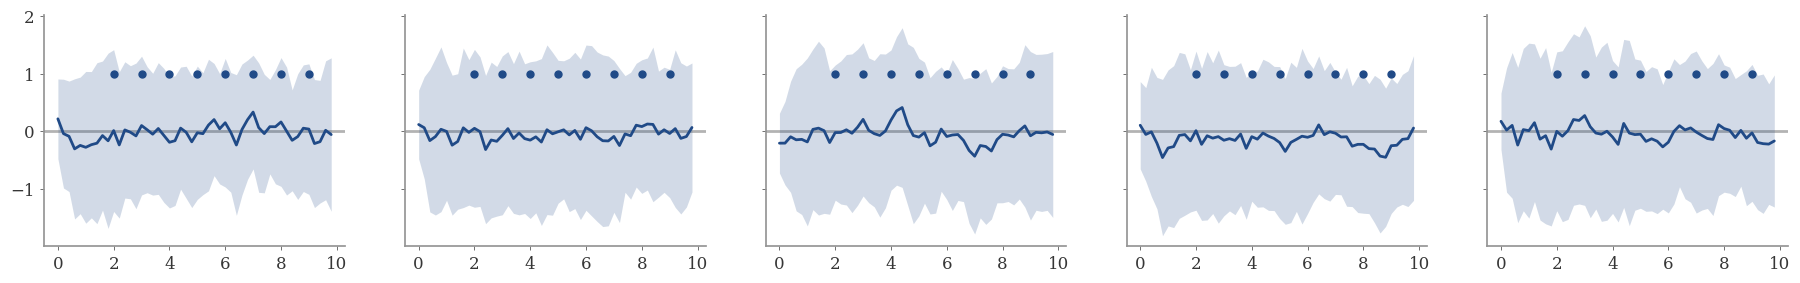

In [4]:
# Plot output
from task_generators import fixed_points as task_generator
task_gen = task_generator(dim_in, dim_out, dt, **task_params)
task_params_ev = deepcopy(task_params)
task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
task_ev = ts_ev, input_ev, target_ev, mask_ev
ts_ev, input_ev, target_ev, mask_ev,  = [to_dev(arr) for arr in task_ev]
n_t_ev = len(ts_ev)

n_cols = n_dim
n_rows = 1
fig = plt.figure(figsize=(4.5 * n_cols, 3 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex='col', sharey='row')
i_s = 0
i_b = 0
i_sn = n_sn-1
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_dim = i_c
    mi = i_s, i_dim, i_sn
    
    i_if = 1
    c = colors[0]

    output = output_all[i_if][mi]
    # Condition on input
    target_dir = torch.sign(input_ev[:, :1, :])
    torch.where(target_dir == 0., torch.ones(1)[0], target_dir)
    output_cond = output * target_dir
    target_cond = target_ev * target_dir
    plot_samples(ax, ts_ev, output_cond[:, :, 0], c=c)
        
    ax.plot(ts_ev[mask_ev[i_b, :, 0]], target_cond[i_b, :, 0][mask_ev[i_b, :, 0]], 'o', c=colors[0], ms=5)
    # ax.set_ylim(0, None)
    ax.axhline(0, c=c_leg, zorder=-1)

In [5]:
# M in terms of eigenvalues and angles

# Eigenvalues and -vectors of M
ew, ev = torch.linalg.eig(M_all)
# assert torch.allclose(ev.imag, torch.zeros(1)[0])
print((np.abs(ev.numpy().imag) > 0).sum())
ew = ew.real
ev = ev.real
# Sort
sorter = torch.argsort(ew, axis=-1).flip(-1)
n_mi = n_samples, n_dim, n_sn
for mi in np.ndindex(n_mi):
    i_s, i_dim, i_sn = mi
    for step in range(n_steps):
        sort = sorter[mi][step]
        ew[mi][step] = ew[mi][step][sort]
        ev[mi][step] = ev[mi][step, :, sort]

ang_wpm_all = torch.zeros((*n_mi, n_steps, rank+1))

for mi in np.ndindex(n_mi):
    i_s, i_dim, i_sn = mi
    dim_hid = dim_hids[i_dim]
    
    # Projection of output vector
    U = sd_if_all[1][mi]["U"]
    w_out = sd_if_all[1][mi]["decoder.weight"]
    v_out = w_out[0] @ U / np.sqrt(dim_hid)
    
    # Choose sign of eigenvectors such that correlation is positive
    ev[mi] = ev[mi] * torch.sign((ev[mi] * v_out[None, :, None]).sum(axis=-2))[:, None, :]

    # Angle between eigenvector and output vector
    v0 = v_out
    v0 = v0 / torch.linalg.norm(v0)
    for step, i_r in np.ndindex(n_steps, rank):
        v1 = ev[mi][step, :, i_r]
        v1 = v1 / torch.linalg.norm(v1)
        # minor = torch.linalg.det(torch.stack((v0[-2:], v1[-2:])))
        minor = torch.linalg.det(torch.stack((v0, v1)))
        ang = torch.sign(minor) * torch.arccos(torch.clip(torch.dot(v0, v1), -1.0, 1.0))
        ang_wpm_all[mi][step, i_r] = ang
    # Angle between eigenvectors
    for step in range(n_steps):
        v0 = ev[mi][step, :, 1]
        v1 = ev[mi][step, :, 0]
        minor = torch.linalg.det(torch.stack((v0, v1)))
        ang_wpm_all[mi][step, 2] = torch.sign(minor) * torch.arccos(torch.clip(torch.dot(v0, v1), -1.0, 1.0))

# Where does the smaller eigenvalue cross?
step_lam_m_max = np.argmax(ew[..., 1], axis=-1)
n_mi = n_samples, n_dim, n_sn
step_cross = np.zeros((n_mi), dtype=int)
for mi in np.ndindex(n_mi):
    i0 = step_lam_m_max[mi]
    if i0 > 50:
        ### Only consider proper crossings...
        step_cross[mi] = np.argmin((ew[mi][i0:, 1] - 0)**2) + i0
    else:
        step_cross[mi] = 0

0


In [6]:
# Angle between input and output vector
# w_out = net.decoder.weight
# w_in = net.rnn_weight_ih_l0
U = sd_if_all[1][mi]["U"]
w_out = sd_if_all[1][mi]["decoder.weight"]
w_in = sd_if_all[1][mi]["rnn_weight_ih_l0"]
v1 = w_out[0] @ U
v1 = v1 / torch.linalg.norm(v1)
v2 = w_in[:, 0] @ U
v2 = v2 / torch.linalg.norm(v2)
minor = torch.linalg.det(torch.stack((v1[-2:], v2[-2:])))
if minor == 0:
    raise NotImplementedError('Too odd vectors =(')
ang_io = torch.sign(minor) * torch.arccos(torch.clip(torch.dot(v1, v2), -1.0, 1.0))
ang_io, np.degrees(ang_io.numpy())

(tensor(1.5708), np.float32(90.0))

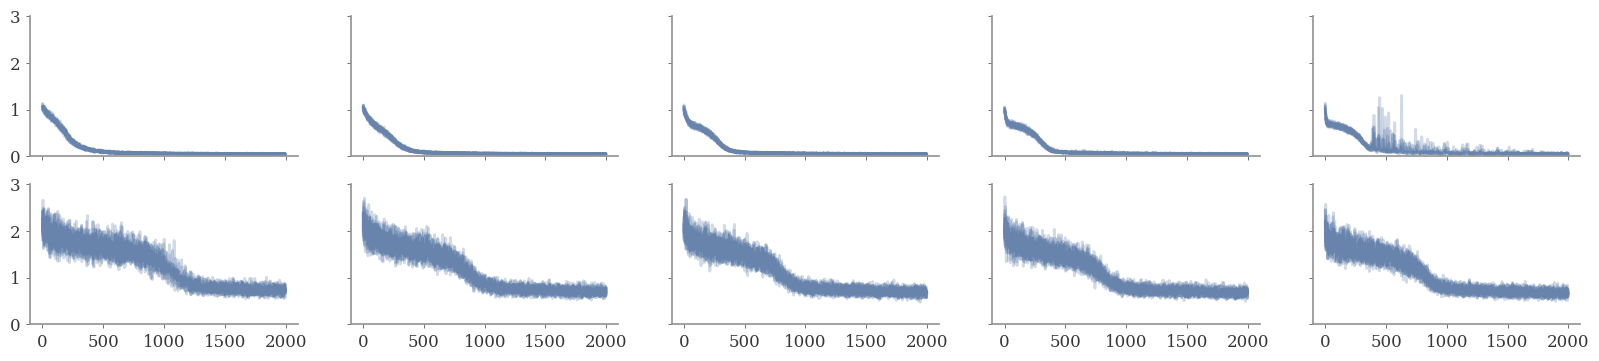

In [7]:

n_cols = n_dim
n_rows = n_sn
fig = plt.figure(figsize=(4 * n_cols, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex='col', sharey='row')
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    
    i_dim = i_c
    i_sn = i_r
    
    plot_samples(ax, steps, loss_all[:, i_dim, i_sn], c=colors[0], mode='all')
    
    ax.set_ylim(0, 3)
    

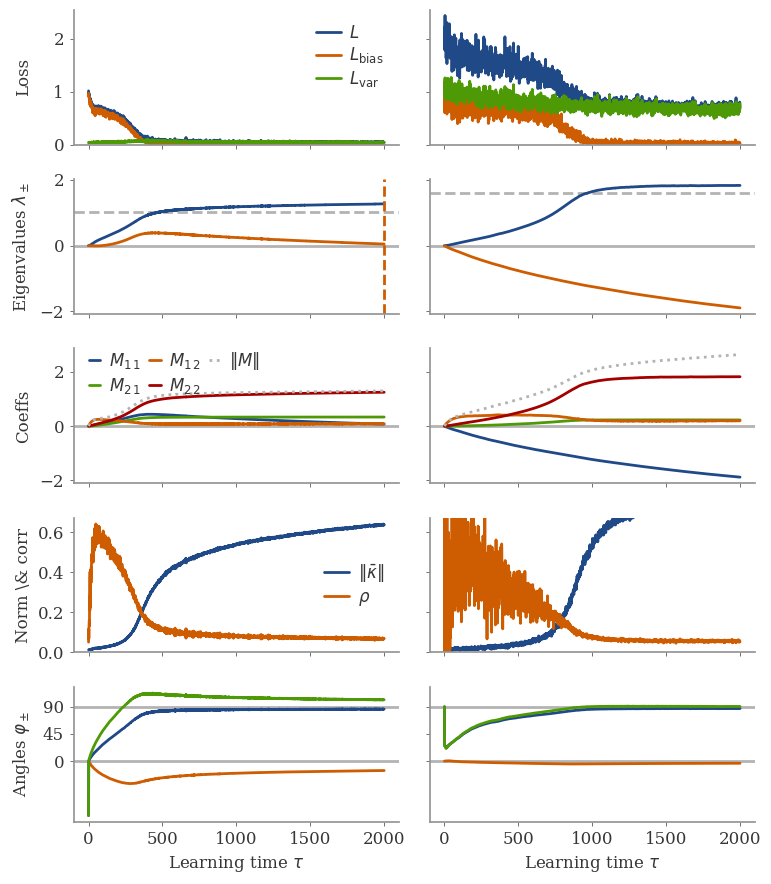

In [13]:
# One plot for slow and fast, respectively
i_sn_show = np.arange(n_sn)
n_cols = len(i_sn_show)
n_rows = 5
fig = plt.figure(figsize=(4 * n_cols, 1.8 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex='col', sharey='row')


i_s = 0
i_dim = n_dim-2


for i_c in range(n_cols):
    i_sn  = i_sn_show[i_c]
    sigma_noise = sigma_noises[i_sn]
    lam_p_min = np.sqrt(1 + 2 * alpha_phi**2 * sigma_noise**2)
    
    mi = i_s, i_dim, i_sn
    
    # Loss
    ax = axes[0, i_c]
    # Different losses
    ax.plot(steps, loss_all[mi], c=colors[0], label=r"$L$")
    ax.plot(steps, loss_bias[mi], c=colors[1], label=r"$L_\mathrm{bias}$")
    ax.plot(steps, loss_var[mi], c=colors[2], label=r"$L_\mathrm{var}$")
    ax.set_ylim(0, )
    ax.set_ylim(0, loss_var[mi].max()*2.)
    if i_c == 0:
        ax.set_ylabel("Loss")
        ax.legend(loc=1, ncol=1, labelspacing=0.2, handlelength=1.5, 
                    handletextpad=0.5, columnspacing=0.5, frameon=False)
    # else:
    #     ax.set_yticklabels([])
    # ax.set_xticklabels([])
    
    # Eigenvalues
    ax = axes[1, i_c]
    for i_rank in range(rank):
        c = colors[i_rank]
        ax.plot(steps, ew[mi][:, i_rank], c=c)
    if step_cross[mi] > 0:
        ax.axvline(step_cross[mi], ls='--', c=colors[1])
    ax.axhline(lam_p_min, ls='--', c=c_leg, zorder=-1)
    ax.axhline(0, c=c_leg, zorder=-1)
    if i_c == 0:
        ax.set_ylabel(r"Eigenvalues $\lambda_\pm$")

    # Entries of M
    ax = axes[2, i_c]
    for j, i in np.ndindex(rank, rank):
        k = rank * i + j
        c=colors[k]
        lbl = r"$M_{%d\,%d}$" % (i+1, j+1)
        ax.plot(steps, M_all[mi][ :, i, j], c=c, label=lbl, alpha=1.)
    # Norm of M
    ax.plot(steps, norm_M_all[mi], ':', c=c_leg, alpha=1., label=r"$\| M \|$")
    ax.axhline(0, c=c_leg, zorder=-1)
    # ax.set_ylim(M_all.min(), M_all.max())
    if i_c == 0:
        ax.set_ylabel("Coeffs")
        ax.legend(loc=2, ncol=3, labelspacing=0.3, handlelength=0.7, 
                    handletextpad=0.5, columnspacing=0.5, frameon=False, 
                 bbox_to_anchor=[0, 1.1])
    ax.set_yticks([-2, 0, 2])
    
    # Evolution of fixed point and correlation
    ax = axes[3, i_c]
    ax.plot(steps, norm_kappa_all[mi], c=colors[0], label=r"$\|\bar{\kappa}\|$")
    ax.plot(steps, rho_all[mi], c=colors[1], label=r"$\rho$")
    ax.set_ylim(0, )
    if i_c == 0:
        ax.legend(loc=5, ncol=1, labelspacing=0.3, handlelength=1.5, 
                    handletextpad=0.5, columnspacing=0.5, frameon=False)
        ax.set_ylabel(r"Norm \& corr")
        
    # Angles
    ax = axes[4, i_c]
    for i_rank in range(rank):
        c = colors[i_rank]
        ax.plot(steps, np.degrees(ang_wpm_all[mi][:, i_rank].numpy()), c=c)
    # Angle between eigenvectors
    ax.plot(steps, np.degrees((ang_wpm_all[mi][:, 0] - ang_wpm_all[mi][:, 1]).numpy()), c=colors[2])
    ax.axhline(0, c=c_leg, zorder=-1)
    ax.axhline(90, c=c_leg, zorder=-1)
    # ax.set_ylim(None, 90)
    ax.set_yticks([0, 45, 90])
    if i_c == 0:
        ax.set_ylabel(r"Angles $\varphi_\pm$")

    # Polish
    ax = axes[-1, i_c]
    ax.set_xlabel(r"Learning time $\tau$")

fig.align_ylabels()
fig.tight_layout()

In [14]:
# Predictions of the theory. 

# 1. For symmetric matrices

# 2. For non-symmetric matrices -> 


### Compare with theory: $\| M \|$ fixed

In [15]:
# Predictions for symmetric matrices only

# Where is learning evaluated?
step_evals = n_steps-1 + np.zeros((n_samples, n_dim, n_sn), dtype=int)
# step_evals = step_cross

# Number of larger eigenvalue lam_+
n_lp = 100

# Results arrays
sigma_x_th, sigma_orth_th, kappa_norm_th, AC_inf_th = np.zeros((4, n_sn, n_lp))
lam_ps = np.zeros((n_sn, n_lp))
ang_wps = np.zeros((n_dim, n_sn, n_lp))

n_mi = n_samples, n_dim, n_sn, n_lp
lam_ms = np.zeros(n_mi)
Vs = np.zeros((*n_mi, 2, 2))
kappa_mean_th = np.zeros((*n_mi, 2))
kappa_cov_th = np.zeros((*n_mi, 2, 2))
L_var_th = np.zeros(n_mi)

assert out_scale == 'large'
w_out_norm = 1.

sigma_orth_th *= np.nan

for i_sn in range(n_sn):
    sigma_noise = sigma_noises[i_sn]

    # Minimal lam_p for avg_dphi and stability. 
    # Note that the minimal lam_p for a solution to exist is in between these two.
    sigma_x_crit_min = sigma_noise if g <= 1 else sigma_noise + 1e-5
    sigma_x_crit = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_crit_min, 10], x0=1.1).root
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    lam_p_stab = np.sqrt((g**4 + 1) / 2)
    sigma_x_stab = np.sqrt((max(1, lam_p_stab**2) - 1) / 2) / alpha_phi
    print(lam_p_crit, lam_p_stab)

    # Larger eigenvalue lam_+
    lam_p_max = norm_M_all[..., i_sn, -1].min() 
    lam_ps[i_sn] = np.linspace(lam_p_crit + 1e-5, lam_p_max, n_lp)

    for i_lp in tqdm(range(n_lp)):
        lam_p = lam_ps[i_sn, i_lp]

        # Compute MFT
        sigma_x, sigma_orth, kappa_norm, AC_inf = comp_MFT_g0(lam_p, sigma_noise)
        # Save
        sigma_x_th[i_sn, i_lp] = sigma_x
        sigma_orth_th[i_sn, i_lp] = sigma_orth
        kappa_norm_th[i_sn, i_lp] = kappa_norm
        AC_inf_th[i_sn, i_lp] = AC_inf

        ### Mean field part of fluctuations
        # Compute noise covariance
        avg_dphi = avg_dphi_func(sigma_x)
        avg_d3phi = avg_d3phi_func(sigma_x)
        avg_phi_sq = avg_func(lambda z: phi(z)**2, sigma_x)
        avg_Phi_dphi = avg_func(lambda z: int_phi(z) * dphi(z), sigma_x)
        q = avg_d3phi / avg_dphi

        # Variance part
        gamma_p = avg_d3phi / avg_dphi * kappa_norm**2
        var_orth = sigma_orth**4 * gamma_p / (2 * (gamma_p - 2)) / kappa_norm**2 

        for i_dim in range(n_dim):
            dim_hid = dim_hids[i_dim]
            cos_ang_wp = z_target / (w_out_norm * np.sqrt(dim_hid) * kappa_norm)

            if np.abs(cos_ang_wp) <= 1:
                # Angle between fixed point and output vector
                ang_wp = np.arccos(cos_ang_wp)
                ang_wps[i_dim, i_sn, i_lp] = ang_wp
                # Angle between output weight and v-. Assume symmetric matrix -> 90deg.
                ang_wm = ang_wp - np.pi/2
                ang_pm = ang_wp - ang_wm
                rho_pm = np.cos(ang_pm)

                for i_s in range(n_samples):
                    mi = i_s, i_dim, i_sn, i_lp
                    
                    # Where is learning evaluated?
                    step_eval = step_evals[i_s, i_dim, i_sn]
                    
                    ### Fix lam_-
                    lam_m = ew[i_s, i_dim, i_sn, step_eval, 1]
                    # ### Alternative: Fix norm and compute lambda_- via the angle between v_+ and v_-
                    # norm_M = norm_M_all[i_s, i_dim, i_sn, step_eval] 
                    # sqrt_arg = norm_M**2 * (1 - rho_pm**2) - (1 - rho_pm**4) * lam_p**2
                    # if sqrt_arg >= 0:
                    #     lam_m = rho_pm**2 * lam_p - np.sqrt(sqrt_arg)
                    # if sqrt_arg >= 0:
                    #     norm_M = np.sqrt(
                    #         (lam_p**2 + lam_m**2 - 2 * lam_p * lam_m * rho_pm**2) / (1 - rho_pm**2)
                    #     )
                    # else:
                    #     lam_ms[mi] = np.nan
                    #     Vs[mi] = np.nan
                    #     kappa_mean_th[mi] = np.nan
                    #     kappa_cov_th[mi] = np.nan
                    #     L_var_th[mi] = np.nan

                    # Compute M
                    M, V = comp_M(lam_p, lam_m, ang_wp, ang_wm)
                    v_p = V[:, 0]
                    kappa_mean = kappa_norm * v_p

                    A_k = -Id + avg_dphi * M + q * kappa_mean[:, None] * kappa_mean[None, :]
                    ev_A_k = np.linalg.eigvals(A_k)
                    assert max(ev_A_k < 0)
                    Q_k = 2 * sigma_noise**2 * Id
                    Sigma_A = solve_lyapunov(A_k, -Q_k)
                    Sigma_orth = var_orth * v_p[:, None] * v_p[None, :]

                    # Stochastic loss
                    kappa_cov = Sigma_A + Sigma_orth
                    L_var = w_out_norm**2 * kappa_cov[0, 0]

                    # Save
                    lam_ms[mi] = lam_m
                    Vs[mi] = V
                    kappa_mean_th[mi] = kappa_mean
                    kappa_cov_th[mi] = kappa_cov
                    L_var_th[mi] = L_var
            else:
                for i_s in range(n_samples):
                    mi = i_s, i_dim, i_sn, i_lp
                    ang_wps[i_dim, i_sn, i_lp] = np.nan
                    lam_ms[mi] = np.nan
                    Vs[mi] = np.nan
                    kappa_mean_th[mi] = np.nan
                    kappa_cov_th[mi] = np.nan
                    L_var_th[mi] = np.nan
                    
# Find local minima in loss
n_mi = n_samples, n_dim, n_sn
lam_p_opt, ang_wm_opt, kappa_norm_opt, ang_wp_opt, lam_m_opt, L_var_opt = np.zeros((6, *n_mi))
for mi in np.ndindex(n_mi):
    i_s, i_dim, i_sn = mi
    dim_hid = dim_hids[i_dim]

    z = L_var_th[mi]
    i_lp_min = np.nanargmin(z)
    lam_p_opt[mi] = lam_ps[i_sn, i_lp_min]
    # Corresponding fixed point
    ang_wp = ang_wps[i_dim, i_sn, i_lp_min]
    ang_wp_opt[mi] = ang_wp
    ang_wm_opt = ang_wp - np.pi/2
    kappa_norm_opt[mi] = kappa_norm_th[i_sn, i_lp_min]
    lam_m_opt[mi] = lam_ms[mi][i_lp_min]
    L_var_opt[mi] = np.nanmin(z)
rho_opt = np.cos(ang_wp_opt)

### Also iterate over angle between v- and w_out??
### For iteration:
# # Angle of second eigenvector
# n_am = 41
# ang_wms = np.radians(np.linspace(-45, 45, n_am))
                # for i_am, i_s in np.ndindex((n_am, n_samples)):
                #     mi = i_lp, i_am, i_s, i_dim, i_sn
                #     ang_wm = ang_wms[i_am]
                #     ang_pm = ang_wp - ang_wm
                ### Then compute lam- for fixed norm. 
                ### Else theres a solution with almost parallel eigenvectors, very high norm.
### For minimum:
    # im = np.nanargmin(z)
    # i_lp_min = im // z.shape[1]
    # i_am_min = im % z.shape[1]


1.0309373662215353 0.7071067811865476


100%|██████████████████████████████████████████████████████| 100/100 [00:00<00:00, 153.15it/s]


1.6033703024550805 0.7071067811865476


100%|██████████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.96it/s]


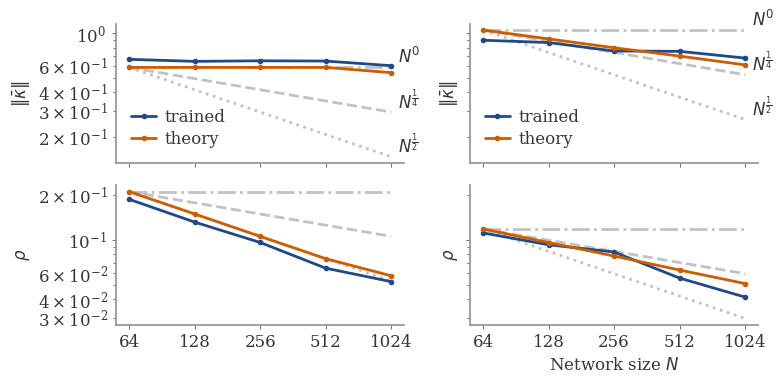

In [16]:
# Plot the results of MFT
n_cols = n_sn
n_rows = 2
fig = plt.figure(figsize=(4 * n_cols, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex='col', sharey='row')

x = np.log(dim_hids)
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_sn = i_c
    
    lbl = [
        r"$\|\bar{\kappa}\|$",
        r"$\rho$",
        r"$\varphi_-$",
        r"$\varphi_\pm$",
        r"$L_\mathrm{var}$",
    ][i_r]
    ax.set_ylabel(lbl)
    
    y_sim = [
        norm_kappa_all,
        rho_all,
        ang_wpm_all[..., 1],
        ang_wpm_all[..., 2],
        loss_var,
            # ][i_r][..., i_sn, -1]
            ][i_r][np.arange(n_samples), np.arange(n_dim), i_sn, step_evals[:, :, i_sn]]
    y_th = [
        kappa_norm_opt,
        rho_opt,
        ang_wm_opt,
        ang_wp_opt - ang_wm_opt,
        L_var_opt,
    ][i_r][..., i_sn]
    for i_st in range(2):
        c = colors[i_st]
        lbl = ["trained", "theory"][i_st]
        y = [y_sim, y_th][i_st]
        plot_samples(ax, x, y, 'o-', c=c, label=lbl)

    # Scales
    ks = -np.array([0, 0.25, 0.5])
    lss = ['-.', '--', ':']
    c = c_leg
    for i_k, k in enumerate(ks):
        y_pow = dim_hids**k * (y.mean(0)[0] / dim_hids[0]**k)
        ls = lss[i_k]
        ax.plot(x, y_pow, ls, c=c, alpha=0.8, zorder=-1)
        if i_r == 0:
            lbl = [
                r"$N^0$",
                r"$N^\frac{1}{4}$",
                r"$N^\frac{1}{2}$",
            ][i_k]
            ax.text(x[-1]*1.01, y_pow[-1], lbl, ha='left', va='bottom')

    if i_r == 0:
        ax.legend(loc=3, ncol=1, labelspacing=0.3, handlelength=1.5, markerscale=1., 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
    
    if i_r in [0, 1]:
        ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xticklabels(dim_hids)
ax.set_xlabel(r"Network size $N$")

fig.align_ylabels()
fig.tight_layout()

Save figure to ../figures/fig_13_fp_mft_train.both


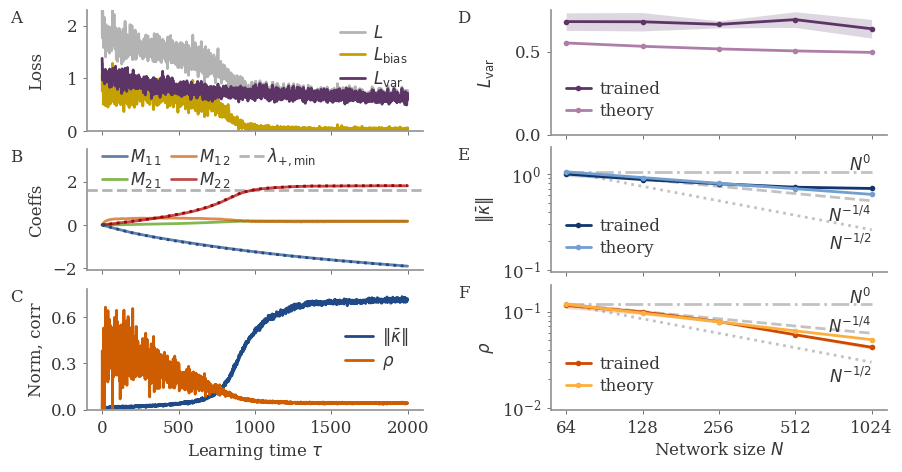

In [22]:
# Join plots
fig = plt.figure(figsize=(8, 4))
i_sn = n_sn-1

# Loss
n_r_L = 3
n_c_L = 1
gs0 = GridSpec(n_r_L, n_c_L)
gs0.update(left=0., right=0.42, bottom=0., top=1., wspace=0., hspace=0.15)
axes_L = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_L)] for k in range(n_r_L)])
# Scales
n_r_sc = 3
n_c_sc = 1
gs0 = GridSpec(n_r_sc, n_c_sc)
gs0.update(left=0.58, right=1., bottom=0., top=1., wspace=0., hspace=0.1)
axes_sc = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_sc)] for k in range(n_r_sc)])
i_c = 0


############################################################################
### Learning
axes = axes_L
i_s = 0
sigma_noise = sigma_noises[i_sn]
i_dim = n_dim-1
mi = i_s, i_dim, i_sn
# Loss
ax = axes[0, i_c]
# Different losses
ax.plot(steps, loss_all[mi], c=c_leg, label=r"$L$")
ax.plot(steps, loss_bias[mi], c=colors[5], label=r"$L_\mathrm{bias}$")
ax.plot(steps, loss_var[mi], c=colors[4], label=r"$L_\mathrm{var}$")
ax.set_ylim(0, 2.3)
if i_c == 0:
    ax.set_ylabel("Loss")
    ax.legend(loc=1, ncol=1, labelspacing=0.2, handlelength=1.5, 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
ax.set_xticklabels([])


# Entries of M
lam_p_min = np.sqrt(1 + 2 * alpha_phi**2 * sigma_noise**2)
ax = axes[1, i_c]
for j, i in np.ndindex(rank, rank):
    k = rank * i + j
    c=colors[k]
    lbl = r"$M_{%d\,%d}$" % (i+1, j+1)
    ax.plot(steps, M_all[mi][ :, i, j], c=c, label=lbl, alpha=0.7)
# # Eigenvalues
for i_rank in range(rank):
    c = colors[[3, 0][i_rank]]
    ax.plot(steps, ew[mi][:, i_rank], ':', c=c)
ax.axhline(lam_p_min, ls='--', c=c_leg, zorder=-1, label=r"$\lambda_{+, \mathrm{min}}$")
# # Norm of M
# ax.plot(steps, norm_M_all[mi], ':', c=c_leg, alpha=1., label=r"$\| M \|$")
# ax.axhline(0, c=c_leg, zorder=-1)
# ax.set_ylim(M_all.min(), M_all.max())
if i_c == 0:
    ax.set_ylabel("Coeffs")
    ax.legend(loc=2, ncol=3, labelspacing=0.2, handlelength=1.5, 
                handletextpad=0.2, columnspacing=0.5, frameon=False, 
             bbox_to_anchor=[0, 1.15])
ax.set_ylim(-2.1, 3.5)
ax.set_yticks([-2., 0, 2.])
ax.set_xticklabels([])

# Evolution of fixed point and correlation
ax = axes[2, i_c]
ax.plot(steps, norm_kappa_all[mi], c=colors[0], label=r"$\|\bar{\kappa}\|$")
ax.plot(steps, rho_all[mi], c=colors[1], label=r"$\rho$")
ax.set_ylim(0, )
if i_c == 0:
    ax.legend(loc=5, ncol=1, labelspacing=0.3, handlelength=1.7, 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
    ax.set_ylabel(r"Norm, corr")
ax.set_yticks([0, 0.3, 0.6])

# Polish
ax = axes[-1, i_c]
ax.set_xlabel(r"Learning time $\tau$")


############################################################################
# Scales
axes = axes_sc
x = np.log(dim_hids)
for i_r in range(n_r_sc):
    ax = axes[i_r, i_c]
    lbl = [
        r"$L_\mathrm{var}$",
        r"$\|\bar{\kappa}\|$",
        r"$\rho$",
        r"$\varphi_-$",
        r"$\varphi_\pm$",
    ][i_r]
    ax.set_ylabel(lbl)
    
    y_sim = [
        loss_var,
        norm_kappa_all,
        rho_all,
        ang_wpm_all[..., 1],
        ang_wpm_all[..., 2],
            ][i_r][..., i_sn, -1]
    y_th = [
        L_var_opt,
        kappa_norm_opt,
        rho_opt,
        ang_wm_opt,
        ang_wp_opt - ang_wm_opt,
    ][i_r][..., i_sn]
    for i_st in range(2):
        cs_sc = cs[[4, 0, 1]]
        c = cs_sc[i_r, [0, 2][i_st]]
        # c = colors[i_st]
        lbl = ["trained", "theory"][i_st]
        y = [y_sim, y_th][i_st]
        plot_samples(ax, x, y, 'o-', c=c, label=lbl)

    # Scales
    ks = -np.array([0, 0.25, 0.5])
    lss = ['-.', '--', ':']
    c = c_leg
    if i_r in [1, 2]:
        ax.set_yscale('log')
        for i_k, k in enumerate(ks):
            y_pow = dim_hids**k * (y.mean(0)[0] / dim_hids[0]**k)
            ls = lss[i_k]
            ax.plot(x, y_pow, ls, c=c, alpha=0.8, zorder=-1)
            # if i_r == 0:
            lbl = [
                r"$N^0$",
                r"$N^{-1/4}$",
                r"$N^{-1/2}$",
            ][i_k]
            id_pos = [-1, -1, -1][i_k]
            yfac = [1.5, 1.5, 0.9][i_k]
            pos_x = x[id_pos]
            pos_y = y_pow[id_pos] * yfac
            if i_r == 1 and i_k == 1:
                pos_y = y_pow[id_pos] * 0.9
            ax.text(pos_x, pos_y, lbl, ha='right', va='top')
            # ax.text(x[-1]*1.005, y_pow[-1], lbl, ha='left', va='center')
            
        ymin = [0, 0.95e-1, 0.95e-2][i_r]
        ymax = [1, 1.9e0, 1.9e-1][i_r]
        ax.set_ylim(ymin, ymax)
    else:
        ax.set_ylim(0, )

    if i_c == 0:
        ax.legend(loc=3, ncol=1, labelspacing=0.3, handlelength=1.5, markerscale=1., 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
    ax.set_xticks(x)
    if i_r == n_r_sc - 1:
        ax.set_xticklabels(dim_hids)
        ax.set_xlabel(r"Network size $N$")
    else:
        ax.set_xticklabels([])

fig.align_ylabels(axes_L)
fig.align_ylabels(axes_sc)

# Label plots
for i in range(len(fig.axes)):
    ax = fig.axes[i]
    if i < n_r_L:
        xpos = -0.21
    else:
        xpos = -0.26
    ypos = 1.0
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)
    
fig_name = ("fig_13_fp_mft_train").replace('.', '_')
saving_fig(fig, figure_path, fig_name, data_type='both')

## Small noise: lam- first increases, then decreases -> O(1) kappa

In [25]:
# Load
data_file = '../data/fp_train_small_noise.pkl'
with open(data_file, 'rb') as handle:
    variables = pickle.load(handle)
print("Added to global:")
for key, var in variables.items():
    print(' ', key)
    globals()[key] = var
n_sn = len(sigma_noises)

Added to global:
  z_target
  sigma_noises
  dim_hids
  n_dim
  lr0
  n_steps
  M_init
  n_samples
  n_mi
  rank
  g
  train_in
  train_hid
  train_out
  train_layers
  alpha_phi
  rnn_num_layers
  h_0_std
  rho_sqrtN
  out_scale
  noise_input_std
  noise_init_std
  noise_hid_std
  n_fp
  dim_in
  dim_out
  dt
  rec_step_dt
  mask_step_dt
  t_max
  t_loss_min
  target_amp
  batch_size
  task_params
  n_if
  n_ifn
  steps
  loss_all
  output_all
  sd_if_all
  kappa_all
  loss_bias
  loss_var
  M_all
  norm_M_all
  norm_kappa_all
  rho_all


In [27]:
# M in terms of eigenvalues and angles

# Eigenvalues and -vectors of M
ew, ev = torch.linalg.eig(M_all)
# assert torch.allclose(ev.imag, torch.zeros(1)[0])
print((np.abs(ev.numpy().imag) > 0).sum())
ew = ew.real
ev = ev.real
# Sort
sorter = torch.argsort(ew, axis=-1).flip(-1)
n_mi = n_samples, n_dim, n_sn
for mi in np.ndindex(n_mi):
    i_s, i_dim, i_sn = mi
    for step in range(n_steps):
        sort = sorter[mi][step]
        ew[mi][step] = ew[mi][step][sort]
        ev[mi][step] = ev[mi][step, :, sort]

ang_wpm_all = torch.zeros((*n_mi, n_steps, rank+1))

for mi in np.ndindex(n_mi):
    i_s, i_dim, i_sn = mi
    dim_hid = dim_hids[i_dim]
    
    # Projection of output vector
    U = sd_if_all[1][mi]["U"]
    w_out = sd_if_all[1][mi]["decoder.weight"]
    v_out = w_out[0] @ U / np.sqrt(dim_hid)
    
    # Choose sign of eigenvectors such that correlation is positive
    ev[mi] = ev[mi] * torch.sign((ev[mi] * v_out[None, :, None]).sum(axis=-2))[:, None, :]

    # Angle between eigenvector and output vector
    v0 = v_out
    v0 = v0 / torch.linalg.norm(v0)
    for step, i_r in np.ndindex(n_steps, rank):
        v1 = ev[mi][step, :, i_r]
        v1 = v1 / torch.linalg.norm(v1)
        # minor = torch.linalg.det(torch.stack((v0[-2:], v1[-2:])))
        minor = torch.linalg.det(torch.stack((v0, v1)))
        ang = torch.sign(minor) * torch.arccos(torch.clip(torch.dot(v0, v1), -1.0, 1.0))
        ang_wpm_all[mi][step, i_r] = ang
    # Angle between eigenvectors
    for step in range(n_steps):
        v0 = ev[mi][step, :, 1]
        v1 = ev[mi][step, :, 0]
        minor = torch.linalg.det(torch.stack((v0, v1)))
        ang_wpm_all[mi][step, 2] = torch.sign(minor) * torch.arccos(torch.clip(torch.dot(v0, v1), -1.0, 1.0))

# Where does the smaller eigenvalue cross?
step_lam_m_max = np.argmax(ew[..., 1], axis=-1)
n_mi = n_samples, n_dim, n_sn
step_cross = np.zeros((n_mi), dtype=int)
for mi in np.ndindex(n_mi):
    i0 = step_lam_m_max[mi]
    if i0 > 50:
        ### Only consider proper crossings...
        step_cross[mi] = np.argmin((ew[mi][i0:, 1] - 0)**2) + i0
    else:
        step_cross[mi] = 0

0


In [30]:
# Predictions for symmetric matrices only

# Where is learning evaluated?
step_evals = np.array(
    [
        step_cross,
        n_steps-1 + np.zeros((n_samples, n_dim, n_sn), dtype=int),
    ])
n_ev = len(step_evals)

# Number of larger eigenvalue lam_+
n_lp = 100

# Results arrays
sigma_x_th, sigma_orth_th, kappa_norm_th, AC_inf_th = np.zeros((4, n_sn, n_lp))
lam_ps = np.zeros((n_sn, n_lp))
ang_wps = np.zeros((n_dim, n_sn, n_lp))

n_mi = n_ev, n_samples, n_dim, n_sn, n_lp
lam_ms = np.zeros(n_mi)
Vs = np.zeros((*n_mi, 2, 2))
kappa_mean_th = np.zeros((*n_mi, 2))
kappa_cov_th = np.zeros((*n_mi, 2, 2))
L_var_th = np.zeros(n_mi)

assert out_scale == 'large'
w_out_norm = 1.

sigma_orth_th *= np.nan

for i_sn in range(n_sn):
    sigma_noise = sigma_noises[i_sn]

    # Minimal lam_p for avg_dphi and stability. 
    # Note that the minimal lam_p for a solution to exist is in between these two.
    sigma_x_crit_min = sigma_noise if g <= 1 else sigma_noise + 1e-5
    sigma_x_crit = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_crit_min, 10], x0=1.1).root
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    lam_p_stab = np.sqrt((g**4 + 1) / 2)
    sigma_x_stab = np.sqrt((max(1, lam_p_stab**2) - 1) / 2) / alpha_phi
    print(lam_p_crit, lam_p_stab)

    # Larger eigenvalue lam_+
    lam_p_max = norm_M_all[..., i_sn, -1].min() 
    lam_ps[i_sn] = np.linspace(lam_p_crit + 1e-5, lam_p_max, n_lp)

    for i_lp in tqdm(range(n_lp)):
        lam_p = lam_ps[i_sn, i_lp]

        # Compute MFT
        sigma_x, sigma_orth, kappa_norm, AC_inf = comp_MFT_g0(lam_p, sigma_noise)
        # Save
        sigma_x_th[i_sn, i_lp] = sigma_x
        sigma_orth_th[i_sn, i_lp] = sigma_orth
        kappa_norm_th[i_sn, i_lp] = kappa_norm
        AC_inf_th[i_sn, i_lp] = AC_inf

        ### Mean field part of fluctuations
        # Compute noise covariance
        avg_dphi = avg_dphi_func(sigma_x)
        avg_d3phi = avg_d3phi_func(sigma_x)
        avg_phi_sq = avg_func(lambda z: phi(z)**2, sigma_x)
        avg_Phi_dphi = avg_func(lambda z: int_phi(z) * dphi(z), sigma_x)
        q = avg_d3phi / avg_dphi

        # Variance part
        gamma_p = avg_d3phi / avg_dphi * kappa_norm**2
        var_orth = sigma_orth**4 * gamma_p / (2 * (gamma_p - 2)) / kappa_norm**2 

        for i_dim in range(n_dim):
            dim_hid = dim_hids[i_dim]
            cos_ang_wp = z_target / (w_out_norm * np.sqrt(dim_hid) * kappa_norm)

            if np.abs(cos_ang_wp) <= 1:
                # Angle between fixed point and output vector
                ang_wp = np.arccos(cos_ang_wp)
                ang_wps[i_dim, i_sn, i_lp] = ang_wp

                # Angle between lam_+, lam_-: 90 deg, as we assume a symmetric matrix.
                ang_pm = np.pi/2
                rho_pm = np.cos(ang_pm)
                # Angle between output weight and v-
                ang_wm = ang_wp - ang_pm

                for i_ev, i_s in np.ndindex(n_ev, n_samples):
                    mi = i_ev, i_s, i_dim, i_sn, i_lp
                    
                    # Where is learning evaluated?
                    step_eval = step_evals[i_ev, i_s, i_dim, i_sn]
                    
                    ### Fix lam_-
                    lam_m = ew[i_s, i_dim, i_sn, step_eval, 1]
                    # ### Alternative: Fix norm and compute lambda_- via the angle between v_+ and v_-
                    # norm_M = norm_M_all[i_s, i_dim, i_sn, step_eval] 
                    # sqrt_arg = norm_M**2 * (1 - rho_pm**2) - (1 - rho_pm**4) * lam_p**2
                    # if sqrt_arg >= 0:
                    #     lam_m = rho_pm**2 * lam_p - np.sqrt(sqrt_arg)
                    # if sqrt_arg >= 0:
                    #     norm_M = np.sqrt(
                    #         (lam_p**2 + lam_m**2 - 2 * lam_p * lam_m * rho_pm**2) / (1 - rho_pm**2)
                    #     )
                    # else:
                    #     lam_ms[mi] = np.nan
                    #     Vs[mi] = np.nan
                    #     kappa_mean_th[mi] = np.nan
                    #     kappa_cov_th[mi] = np.nan
                    #     L_var_th[mi] = np.nan

                    # Compute M
                    M, V = comp_M(lam_p, lam_m, ang_wp, ang_wm)
                    v_p = V[:, 0]
                    kappa_mean = kappa_norm * v_p

                    A_k = -Id + avg_dphi * M + q * kappa_mean[:, None] * kappa_mean[None, :]
                    ev_A_k = np.linalg.eigvals(A_k)
                    assert max(ev_A_k < 0)
                    Q_k = 2 * sigma_noise**2 * Id
                    Sigma_A = solve_lyapunov(A_k, -Q_k)
                    Sigma_orth = var_orth * v_p[:, None] * v_p[None, :]

                    # Stochastic loss
                    kappa_cov = Sigma_A + Sigma_orth
                    L_var = w_out_norm**2 * kappa_cov[0, 0]

                    # Save
                    lam_ms[mi] = lam_m
                    Vs[mi] = V
                    kappa_mean_th[mi] = kappa_mean
                    kappa_cov_th[mi] = kappa_cov
                    L_var_th[mi] = L_var
            else:
                for i_ev, i_s in np.ndindex(n_ev, n_samples):
                    mi = i_ev, i_s, i_dim, i_sn, i_lp
                    ang_wps[i_dim, i_sn, i_lp] = np.nan
                    lam_ms[mi] = np.nan
                    Vs[mi] = np.nan
                    kappa_mean_th[mi] = np.nan
                    kappa_cov_th[mi] = np.nan
                    L_var_th[mi] = np.nan
                    
# Find local minima in loss
n_mi = n_ev, n_samples, n_dim, n_sn
lam_p_opt, ang_wm_opt, kappa_norm_opt, ang_wp_opt, lam_m_opt, L_var_opt = np.zeros((6, *n_mi))
for mi in np.ndindex(n_mi):
    i_ev, i_s, i_dim, i_sn = mi
    dim_hid = dim_hids[i_dim]

    z = L_var_th[mi]
    i_lp_min = np.nanargmin(z)
    lam_p_opt[mi] = lam_ps[i_sn, i_lp_min]
    # Corresponding fixed point
    ang_wp = ang_wps[i_dim, i_sn, i_lp_min]
    ang_wp_opt[mi] = ang_wp
    ang_wm_opt = ang_wp - np.pi/2
    kappa_norm_opt[mi] = kappa_norm_th[i_sn, i_lp_min]
    lam_m_opt[mi] = lam_ms[mi][i_lp_min]
    L_var_opt[mi] = np.nanmin(z)
rho_opt = np.cos(ang_wp_opt)

1.0309373662215353 0.7071067811865476


100%|██████████████████████████████████████████████████████| 100/100 [00:00<00:00, 300.33it/s]


Save figure to ../figures/fig_28_fp_mft_train_small_noise.both


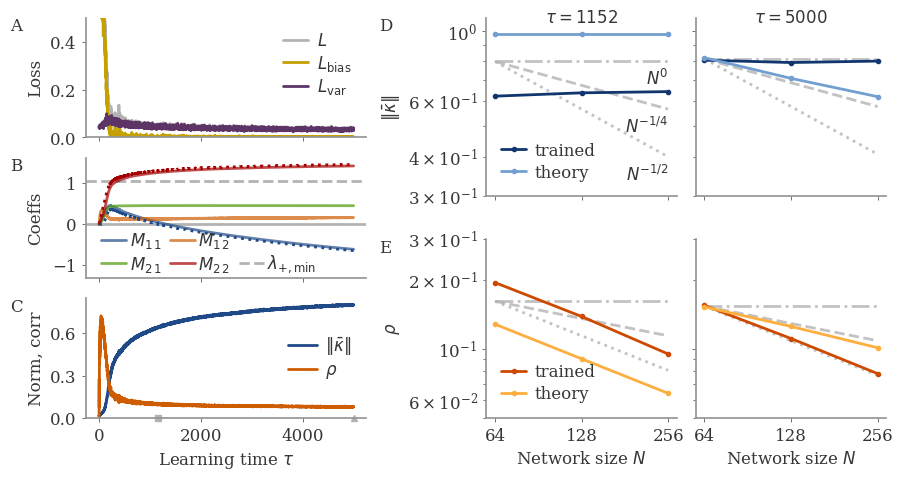

In [41]:
# Join plots
fig = plt.figure(figsize=(8, 4))
i_sn = n_sn-1

# Loss
n_r_L = 3
n_c_L = 1
gs0 = GridSpec(n_r_L, n_c_L)
gs0.update(left=0., right=0.35, bottom=0., top=1., wspace=0.1, hspace=0.17)
axes_L = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_L)] for k in range(n_r_L)])
# Scales
n_r_sc = 2
n_c_sc = 2
gs0 = GridSpec(n_r_sc, n_c_sc)
gs0.update(left=0.50, right=1., bottom=0., top=1., wspace=0.1, hspace=0.24)
axes_sc = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_c_sc)] for k in range(n_r_sc)])
i_c = 0


############################################################################
### Learning
axes = axes_L
i_s = 0
sigma_noise = sigma_noises[i_sn]
i_dim = n_dim-1
mi = i_s, i_dim, i_sn
# Loss
ax = axes[0, i_c]
# Different losses
ax.plot(steps, loss_all[mi], c=c_leg, label=r"$L$")
ax.plot(steps, loss_bias[mi], c=colors[5], label=r"$L_\mathrm{bias}$")
ax.plot(steps, loss_var[mi], c=colors[4], label=r"$L_\mathrm{var}$")
ax.set_ylim(0, 0.5)
if i_c == 0:
    ax.set_ylabel("Loss")
    ax.legend(loc=1, ncol=1, labelspacing=0.2, handlelength=1.5, 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
ax.set_xticklabels([])


# Entries of M
lam_p_min = np.sqrt(1 + 2 * alpha_phi**2 * sigma_noise**2)
ax = axes[1, i_c]
for j, i in np.ndindex(rank, rank):
    k = rank * i + j
    c=colors[k]
    lbl = r"$M_{%d\,%d}$" % (i+1, j+1)
    ax.plot(steps, M_all[mi][ :, i, j], c=c, label=lbl, alpha=0.7)
# # Eigenvalues
for i_rank in range(rank):
    c = colors[[3, 0][i_rank]]
    ax.plot(steps, ew[mi][:, i_rank], ':', c=c)
ax.plot(0, 0, '-', c='w', alpha=0, label=' ')
ax.axhline(lam_p_min, ls='--', c=c_leg, zorder=-1, label=r"$\lambda_{+, \mathrm{min}}$")
# # Norm of M
# ax.plot(steps, norm_M_all[mi], ':', c=c_leg, alpha=1., label=r"$\| M \|$")
# ax.set_ylim(M_all.min(), M_all.max())
ax.axhline(0, c=c_leg, zorder=-1)
if i_c == 0:
    ax.set_ylabel("Coeffs")
    ax.legend(loc=3, ncol=3, labelspacing=0.2, handlelength=1.5, 
                handletextpad=0.2, columnspacing=0.5, frameon=False, 
             bbox_to_anchor=[0, -0.1])
ax.set_yticks([-1, 0, 1])
ax.set_ylim(-1.3, 1.6)
ax.set_xticklabels([])

# Evolution of fixed point and correlation
ax = axes[2, i_c]
ax.plot(steps, norm_kappa_all[mi], c=colors[0], label=r"$\|\bar{\kappa}\|$")
ax.plot(steps, rho_all[mi], c=colors[1], label=r"$\rho$")
ax.set_ylim(0, )
if i_c == 0:
    ax.legend(loc=5, ncol=1, labelspacing=0.3, handlelength=1.7, 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
    ax.set_ylabel(r"Norm, corr")
ax.set_yticks([0, 0.3, 0.6])

# Polish
ax = axes[-1, i_c]
ax.set_xlabel(r"Learning time $\tau$")

# Where is the right side?
for i_ev in range(n_ev):
    step_eval = step_evals[i_ev, i_s, i_dim, i_sn]
    ax.plot(step_eval, 0, ['s', "^"][i_ev], ms=5, c=c_leg, clip_on=False)

############################################################################
# Scales
axes = axes_sc
x = np.log(dim_hids)
for i_r, i_c in np.ndindex(n_r_sc, n_c_sc):
    ax = axes[i_r, i_c]
    i_ev = i_c
    
    lbl = [
        r"$\|\bar{\kappa}\|$",
        r"$\rho$",
        r"$\varphi_-$",
        r"$\varphi_\pm$",
        r"$L_\mathrm{var}$",
    ][i_r]
    if i_c == 0:
        ax.set_ylabel(lbl)
    y_sim_all = [
        norm_kappa_all,
        rho_all,
        ang_wpm_all[..., 1],
        ang_wpm_all[..., 2],
        loss_var,
            # ][i_r][..., i_sn, -1]
            ][i_r]
    y_sim = y_sim_all[np.arange(n_samples), np.arange(n_dim), i_sn, step_evals[i_ev, :, :, i_sn]]
    y_th_all = [
        kappa_norm_opt,
        rho_opt,
        ang_wm_opt,
        ang_wp_opt - ang_wm_opt,
        L_var_opt,
    ][i_r]
    y_th = y_th_all[i_ev, ..., i_sn]
    for i_st in range(2):
        cs_sc = cs[[0, 1]]
        c = cs_sc[i_r, [0, 2][i_st]]
        # c = colors[i_st]
        lbl = ["trained", "theory"][i_st]
        y = [y_sim, y_th][i_st]
        plot_samples(ax, x, y, 'o-', c=c, label=lbl)

    # Scales
    ks = -np.array([0, 0.25, 0.5])
    lss = ['-.', '--', ':']
    c = c_leg
    for i_k, k in enumerate(ks):
        y_base = 0.5 * (y_sim + y_th).mean(0)
        y_pow = dim_hids**k * (y_base[0] / dim_hids[0]**k)
        ls = lss[i_k]
        ax.plot(x, y_pow, ls, c=c, alpha=0.8, zorder=-1)
        if i_r == 0 and i_c == 0:
            lbl = [
                r"$N^0$",
                r"$N^{-1/4}$",
                r"$N^{-1/2}$",
            ][i_k]
            # ax.text(x[-1]*1.01, y_pow[-1], lbl, ha='left', va='bottom')
            id_pos = [-1, -1, -1]
            pos_x = x[id_pos[i_k]]
            pos_y = y_pow[id_pos[i_k]] * 0.95
            ax.text(pos_x, pos_y, lbl, ha='right', va='top')

    if i_c == 0:# and i_r == 0:
        ax.legend(loc=3, ncol=1, labelspacing=0.3, handlelength=1.5, markerscale=1., 
                handletextpad=0.5, columnspacing=0.5, frameon=False)
    ax.set_xticks(x)
    if i_r == n_r_sc - 1:
        ax.set_xticklabels(dim_hids)
        ax.set_xlabel("Network size $N$")
    else:
        ax.set_xticklabels([])
        
    if i_r in [0, 1]:
        ax.set_yscale('log')
    y_sim_ev = np.array([[
        y_sim_all[np.arange(n_samples), np.arange(n_dim), i_sn, step_evals[i_ev, :, :, i_sn]]
        for i_ev in range(n_ev)] for i_sn in range(n_sn)])
    ymin = min(y_sim_ev.min(), y_th_all.min()) * 0.8
    ymax = max(y_sim_ev.max(), y_th_all.max()) * 1.2
    ymax = [1.1e0, 3e-1][i_r]
    ymin = [3e-1, 5e-2][i_r]
    ax.set_ylim(ymin, ymax)
    if i_c > 0:
        from matplotlib.ticker import NullFormatter
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        
    if i_r == 0:
        lbl = r"$\tau = %d $" % (step_evals[i_ev, i_s, i_dim, i_sn] + 1)
        ax.set_title(lbl, y=1, va='top')
    

fig.align_ylabels(axes_L)
fig.align_ylabels(axes_sc)

# Label plots
# for i in range(5):#len(fig.axes)):
for i, i_ax in enumerate([0, 1, 2, 3, 5]):
    ax = fig.axes[i_ax]
    if i < n_r_L:
        xpos = -0.25
    else:
        xpos = -0.53
    ypos = 1.0
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)
    
fig_name = ("fig_28_fp_mft_train_small_noise").replace('.', '_')
saving_fig(fig, figure_path, fig_name, data_type='both')